In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('./datasets/titanic_train.csv')
test  = pd.read_csv('./datasets/titanic_test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data preparation

In [5]:
data = pd.concat([train, test])

In [6]:
to_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
data.drop(to_drop, axis=1, inplace=True)

data.Sex, mapper_sex      = pd.factorize(data.Sex)
data.Embarked, mapper_emb = pd.factorize(data.Embarked)

data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,0,7.2500,0,3,0,1,0.0
1,38.0,1,71.2833,0,1,1,1,1.0
2,26.0,0,7.9250,0,3,1,0,1.0
3,35.0,0,53.1000,0,1,1,1,1.0
4,35.0,0,8.0500,0,3,0,0,0.0


In [7]:
train = data[~pd.isnull(data.Survived)].fillna(0.0)
test  = data.loc[pd.isnull(data.Survived)].fillna(0.0)

test.drop('Survived', axis=1, inplace=True)

In [8]:
from sklearn.ensemble import RandomForestClassifier

train_x = train.drop('Survived', axis=1)
train_y = train.Survived

rf = RandomForestClassifier(n_estimators=250)
rf.fit(train_x, train_y)

preds = rf.predict(test)

In [10]:
from treeinterpreter import treeinterpreter

In [62]:
pred, bias, contrib = treeinterpreter.predict(rf, test)
contrib = pd.DataFrame(contrib[:,:,1], columns=test.columns)

In [43]:
#test[test.Sex == 1]

In [44]:
test.iloc[14]

Age         47.000
Embarked     0.000
Fare        61.175
Parch        0.000
Pclass       1.000
Sex          1.000
SibSp        1.000
Name: 14, dtype: float64

In [45]:
print(bias[14, 1])
print(sum(contrib.iloc[14]))
print(pred[14, 1])

0.384709315376
0.575290684624
0.96


In [46]:
test.iloc[14]

Age         47.000
Embarked     0.000
Fare        61.175
Parch        0.000
Pclass       1.000
Sex          1.000
SibSp        1.000
Name: 14, dtype: float64

In [63]:
contrib.iloc[14]

Age        -0.015758
Embarked   -0.017586
Fare        0.120025
Parch       0.003994
Pclass      0.142235
Sex         0.327406
SibSp       0.014975
Name: 14, dtype: float64

In [64]:
c = contrib.iloc[14]

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import svgutils.transform as sg

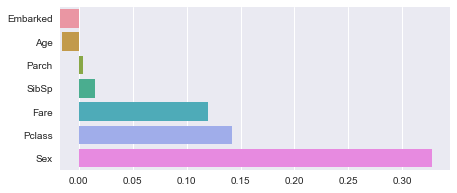

In [65]:
fig = plt.figure(figsize=(7, 3))

srtd = c.sort_values()
sns.barplot(srtd.values, srtd.index)

fig.savefig('../report/img/titanic-treeinterpreter-rich.svg')

In [51]:
cumsum = np.array([sum(c.values[:i]) for i in range(c.shape[0] + 1)]) + bias[14, 1]
labels = ['Base'] + c.index.tolist()

In [25]:
cumsum

array([ 0.38470932,  0.36895123,  0.35136514,  0.47139023,  0.47538409,
        0.61761937,  0.94502548,  0.96      ])

In [29]:
freq = 100.0
xlbl = []
for l in labels:
    xlbl.append(l)
    xlbl.append("")

x = [i / 2 if i % 2 == 0 else int(i / 2) + 0.99 for i in range(len(xlbl))]

y = [cumsum[i / 2] for i in range(len(xlbl))]

/Users/marcbeillevaire/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


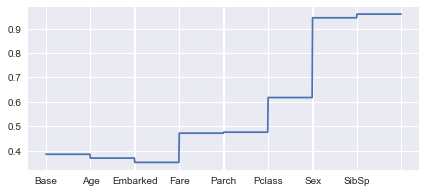

In [31]:
fig = plt.figure(figsize=(7, 3))

plt.xticks(x, xlbl)
plt.plot(x,y)
plt.show()

fig.savefig('../report/img/1-2-2.svg')

## Mode features influence

In [55]:
test.median()

Age         24.0000
Embarked     0.0000
Fare        14.4542
Parch        0.0000
Pclass       3.0000
Sex          0.0000
SibSp        0.0000
dtype: float64

In [60]:
pred, bias, contrib = treeinterpreter.predict(rf, test.mode())
contrib = pd.DataFrame(contrib[:,:,1], columns=test.columns)

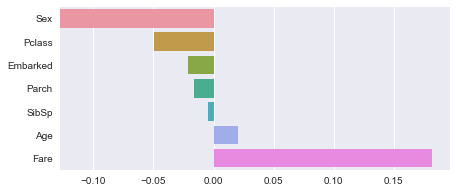

In [61]:
fig = plt.figure(figsize=(7, 3))

c = contrib.loc[0]
srtd = c.sort_values()
sns.barplot(srtd.values, srtd.index)

fig.savefig('../report/img/titanic-treeint-mode.svg')